# Basic Setup

Set up Basic Parameter here

In [1]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Define sample size
N = 10000 # number of subjects
N_T = 5000 # number of treated subjects

# Define betas
beta_11 = 1
beta_12 = 1
beta_21 = 1
beta_22 = 1
beta_23 = 1
beta_31 = 1

#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 12


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



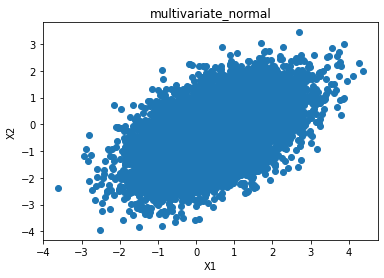

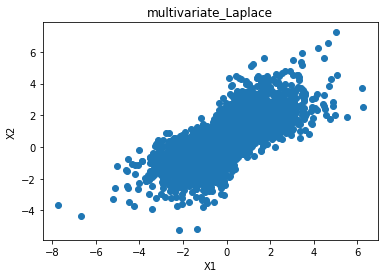

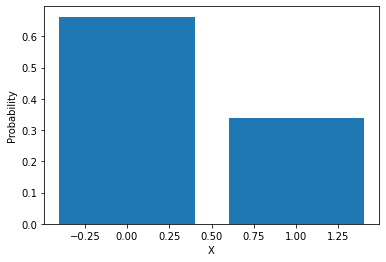

[[ 0.35127003 -0.00669148  0.48677799  0.98376536  0.        ]
 [ 1.71717263  1.67700521  0.27520298  1.60355812  0.        ]
 [ 0.30336023 -0.27623734  0.72837277  2.10859627  0.        ]
 ...
 [ 0.60225078  1.7127982   0.31476812  0.87523958  1.        ]
 [-0.35452159  0.62994936  0.43072705  0.49415766  1.        ]
 [ 0.92810405 -1.41267835 -0.24921594 -0.75785395  1.        ]]


In [3]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [4]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

U


array([[-0.10750081,  1.        ],
       [ 1.31339736,  1.        ],
       [ 1.79540562,  0.        ],
       ...,
       [ 0.30200801,  1.        ],
       [-1.55768262,  0.        ],
       [ 0.72053078,  1.        ]])

# Simulate Z
The observed treatment indicators $\mathbf{Z}=(Z_{1}, \dots, Z_{N})\in \{0, 1\}^{N}$ follow a completely randomized experiment: $P(\mathbf{Z}=\mathbf{z})={N\choose N_{T}}^{-1}$ for any $\mathbf{z}=(z_{1},\dots, z_{N})\in \{0,1\}^{N}$ with $\sum_{n=1}^{N}z_{n}=N_{T}$.

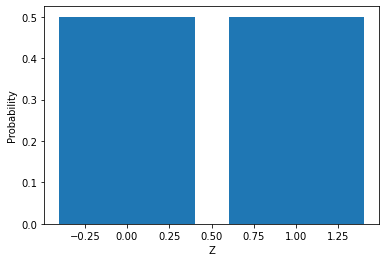

array([0., 1., 0., ..., 0., 1., 1.])

In [5]:
Z = np.zeros(N)
Z[:N_T] = 1
np.random.shuffle(Z)

counts = np.unique(Z, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('Z')
plt.ylabel('Probability')
plt.show()
Z = Z.reshape(-1,)
Z

# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [6]:
#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])


# Calculate Y_n1
Y_n1 = (beta_11 * Z + beta_12 * Z * sum1   + sum2 + np.sin(U_n1) + U_n2) 

# Compute Yn2
Y_n2 = (beta_21 * Z + beta_22 * Z * X[:,0] + beta_23 * Z * U_n1 * U_n2 + sum3 + sum4) 

# Compute Yn3
Y_n3 = (beta_31 * Z + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)) 

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1) 
print(Y.shape)

(10000, 3)


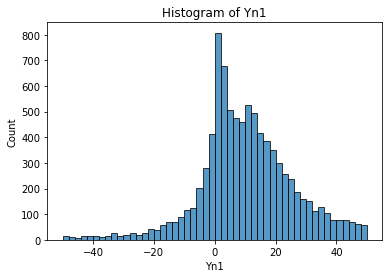

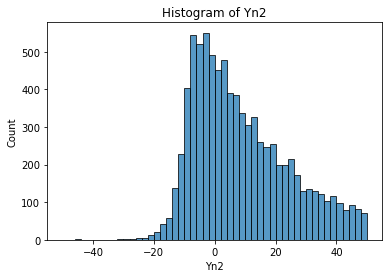

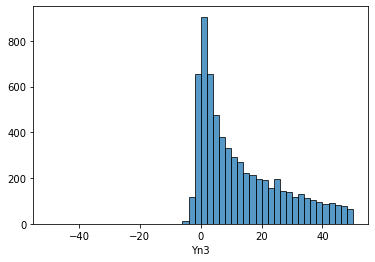

In [7]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [8]:

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3, single = True):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 - single
        else:
          M[i][0] = 0
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] =  1 - single
        else:
          M[i][1] =  0

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] =  0
        else:
          M[i][2] =  1

    return M,M_lamda
M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:31: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:43: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:27: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:33: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
9995,0.0,0.0,0.0
9996,0.0,0.0,0.0
9997,0.0,0.0,0.0
9998,0.0,0.0,0.0


[[3.83335779e+01 3.53966955e+01 4.75794669e+05]
 [3.36148255e+32 2.10195665e+05 9.29198980e+42]
 [6.65415504e+06 1.99530956e+03 8.01160902e+15]
 ...
 [4.59270138e+10 7.48744955e+03 4.84536164e+26]
 [3.49978057e+08 3.83027450e+03 9.53654427e+07]
 [1.19404995e+05 7.99743535e+02 1.58190661e+01]]


[3.83335779e+01 3.36148255e+32 6.65415504e+06 ... 4.59270138e+10
 3.49978057e+08 1.19404995e+05]
[3.83335779e+01 3.53966955e+01 4.75794669e+05]


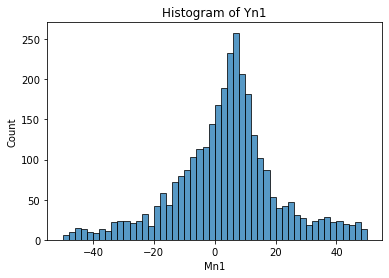

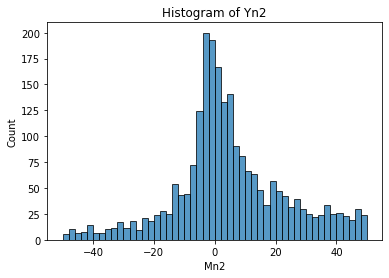

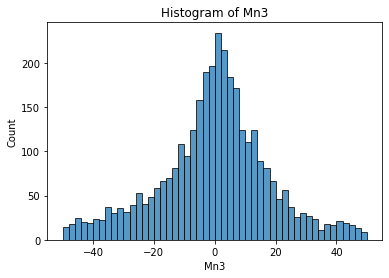

In [9]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [10]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.0
0.0
0.3157


# Save all the simulated data


In [11]:
# Read the data,it is important to put the "Research" directory in ones own google drive
Z = Z.reshape((-1,1))

np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())


print("Sucessfully Saved")

(10000, 5)


,0,1,2,3,4
0,0.351270,-0.006691,0.486778,0.983765,0.0
1,1.717173,1.677005,0.275203,1.603558,0.0
2,0.303360,-0.276237,0.728373,2.108596,0.0
3,0.699926,-1.832527,-0.449712,-0.098141,1.0
4,1.392342,1.469335,0.065477,0.285702,1.0
...,...,...,...,...,...
9995,0.294324,-0.884006,0.694549,0.725856,0.0
9996,2.439932,1.994273,-1.634582,-1.264636,0.0
9997,0.602251,1.712798,0.314768,0.875240,1.0
9998,-0.354522,0.629949,0.430727,0.494158,1.0


                  0             1             2             3             4
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.498888     -0.323509     -0.007475      0.569616      0.337300
std        0.999323      1.004282      1.013408      0.992170      0.472812
min       -3.612707     -3.949841     -7.726543     -5.229377      0.000000
25%       -0.172067     -1.008583     -0.514515      0.082685      0.000000
50%        0.486064     -0.312730     -0.004750      0.568839      0.000000
75%        1.161170      0.352981      0.487213      1.057459      1.000000
max        4.359322      3.446167      6.241048      7.235685      1.000000
(10000, 3)


,0,1,2
0,3.303519,13.072710,25.034843
1,74.895105,98.937727,511.770741
2,15.710748,36.619668,108.607238
3,9.988293,-0.549150,1.703974
4,22.704922,56.992803,240.445090
...,...,...,...
9995,2.549213,5.034245,3.702225
9996,48.589225,37.528051,53.415294
9997,24.550319,61.445234,282.056835
9998,19.673381,18.373226,41.032051


                  0             1              2
count  10000.000000  10000.000000   10000.000000
mean      19.101001     35.848790     235.447987
std       67.614638    273.038101    3426.708359
min     -755.337874    -59.827622      -5.800087
25%        1.619531     -2.104221       4.568493
50%       10.800585      9.525640      23.035209
75%       23.857854     31.581867      88.605398
max     4146.832771  21515.704432  300022.211560
(10000, 1)


,0
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
9995,0.0
9996,1.0
9997,0.0
9998,1.0


                  0
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
(10000, 2)


,0,1
0,-0.107501,1.0
1,1.313397,1.0
2,1.795406,0.0
3,0.196682,1.0
4,-0.132714,1.0
...,...,...
9995,1.426784,0.0
9996,0.909426,0.0
9997,0.302008,1.0
9998,-1.557683,0.0


                  0             1
count  10000.000000  10000.000000
mean       0.502733      0.666600
std        1.002883      0.471452
min       -3.625052      0.000000
25%       -0.166689      0.000000
50%        0.494314      1.000000
75%        1.178198      1.000000
max        4.681280      1.000000
(10000, 3)


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
9995,0.0,0.0,0.0
9996,0.0,0.0,0.0
9997,0.0,0.0,0.0
9998,0.0,0.0,0.0


             0        1             2
count  10000.0  10000.0  10000.000000
mean       0.0      0.0      0.315700
std        0.0      0.0      0.464817
min        0.0      0.0      0.000000
25%        0.0      0.0      0.000000
50%        0.0      0.0      0.000000
75%        0.0      0.0      1.000000
max        0.0      0.0      1.000000
Sucessfully Saved
